In [1]:

from sae_lens import HookedSAETransformer, SAE, SAEConfig
from gemma_utils import get_gemma_2_config, gemma_2_sae_loader

In [2]:

import numpy as np
import torch
import tqdm
import einops
import re
from jaxtyping import Int, Float
from typing import List, Optional, Any
from torch import Tensor
import json
import os
from torch.utils.data import Dataset, DataLoader
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from transformer_lens.utils import get_act_name
from IPython.display import display, HTMtring(3119)L

In [3]:

np.random.seed(0)
random.seed(0)
torch.random.manual_seed(0)

In [4]:

model = HookedSAETransformer.from_pretrained("google/gemma-2-2b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [ ]:

def visualize_html(text):
    text = text.replace("<eos>","")
    text = text.replace("<bos>","")
    display(HTML(text))
    

In [5]:
text = """<body><h1>List of My Brother's Favourite Cities</h1><ul><li>"""
tokens = model.to_tokens(text)
out = model.generate(
    tokens,
    max_new_tokens = 100,
    temperature = 0.7,
    top_p = 0.9,
    stop_at_eos=True,
    )

visualize_html(model.to_string(out[-1]))

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'visualize_html' is not defined

In [44]:
string = "<bos><body><h1>List of My Brother's Favourite Cities</h1><ul><li>Bangkok, Thailand</li><li>London, England</li><li>Paris, France</li><li>Melbourne, Australia</li><li>Toronto, Canada</li><li>New York, USA</li></ul></body>\n<eos>"
tokens = model.to_tokens(string, prepend_bos=False)

At this point and with the changes that we have made to the setup to reliably produce list that don't spiral out of control, we ask ourselves how can the model decide to add another elemnt or not.


Taking into account the moel's tokenization:

- `'<ul>' '<', 'ul', '>'`
- `'><li>' '><', 'li', '>'`
- `'</li>' '</', 'li', '>'`
- `'><ul>' '></', 'ul', '>'`

The model will continue the list while remaining html consistent if it uses the token `><` instead of the token `></`

In [45]:
tok_id = model.to_tokens("></", prepend_bos=False)[0]

tok_id2 = model.to_tokens("><", prepend_bos=False)[0]
tok_pos = torch.where(tokens[0] == tok_id)[0][0].tolist()
all_tok2_pos = torch.where(tokens[0] == tok_id2)[0][1:].tolist()

In [52]:
with torch.no_grad():
    logits = model(tokens)

In [56]:
for elem in all_tok2_pos + [tok_pos]:
    l = logits[0,elem-1]
    print(l[tok_id]-l[tok_id2])
    #print([model.to_str_tokens(i) for i in l.topk(10).indices])

tensor([-2.0125], device='cuda:0')
tensor([-2.1449], device='cuda:0')
tensor([-0.7575], device='cuda:0')
tensor([-0.6126], device='cuda:0')
tensor([-0.0059], device='cuda:0')
tensor([0.2700], device='cuda:0')


## Logit Lens

In [57]:
import pandas as pd

In [62]:
pattern_hook_names_filter = lambda name: name.endswith("hook_resid_pre") or name.endswith("25.hook_resid_post") or  name.endswith('ln_final.hook_scale'

)

with torch.no_grad():
    _,cache = model.run_with_cache(tokens,names_filter = pattern_hook_names_filter)

all_logit_lens = []
for elem in all_tok2_pos + [tok_pos]:
    accumulated_residual, labels = cache.accumulated_resid(
        incl_mid=False, pos_slice=elem-1, return_labels=True,apply_ln = True
    )

    dir = model.W_U[:,tok_id].detach()-model.W_U[:,tok_id2].detach()
    logit_lens = einops.einsum(dir[:,0], accumulated_residual,"d_model,comps batch d_model -> comps batch ")
    all_logit_lens.append(logit_lens)



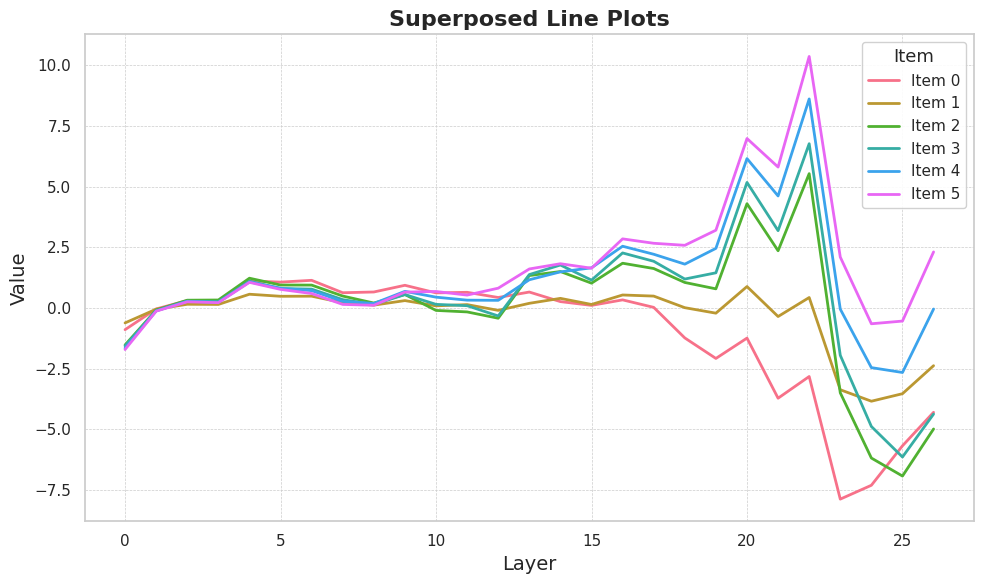

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_superposed_lineplots(data, x, y, hue, title=None, xlabel=None, ylabel=None, 
                              palette='husl', line_styles=None, markers=True, 
                              grid=True, legend=True, legend_loc='best', 
                              figsize=(10, 6), linewidth=2):
    """
    Plots multiple superposed line plots with custom aesthetics using Seaborn.

    Parameters:
        data (pd.DataFrame): DataFrame containing the data.
        x (str): Column name to be used for the x-axis.
        y (str): Column name to be used for the y-axis.
        hue (str): Column name to be used for grouping data (each group gets a different line).
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        palette (str or list): Seaborn color palette or list of colors.
        line_styles (list or dict): List or dictionary of line styles for each hue category.
        markers (bool): Whether to show markers at data points.
        grid (bool): Whether to show grid lines.
        legend (bool): Whether to show the legend.
        legend_loc (str): Location of the legend.
        figsize (tuple): Size of the figure.
        linewidth (int): Width of the lines.
    """
    # Set up the matplotlib figure and size
    plt.figure(figsize=figsize)

    # Apply a Seaborn style
    sns.set(style="whitegrid")

    # Create the line plot
    sns.lineplot(data=data, x=x, y=y, hue=hue, palette=palette, style=hue if line_styles else None, 
                 dashes=line_styles, markers=markers, linewidth=linewidth)
    
    # Customize gridlines
    if grid:
        plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    
    # Set the title and labels
    if title:
        plt.title(title, fontsize=16, fontweight='bold')
    if xlabel:
        plt.xlabel(xlabel, fontsize=14)
    if ylabel:
        plt.ylabel(ylabel, fontsize=14)

    # Customize the legend
    if legend:
        plt.legend(title=hue, loc=legend_loc, title_fontsize='13', fontsize='11', frameon=True, framealpha=0.9)

    # Improve the overall layout
    plt.tight_layout()

    # Show the plot
    plt.show()

import pandas as pd
data_dict = {}
data_dict["Layers"] = list(range(model.cfg.n_layers+1))
for i,tensor in enumerate(all_logit_lens):
    data_dict[f"Item {i}"] =  tensor.cpu().reshape(-1).numpy()

data = pd.DataFrame(data_dict)
                     
# Melt the data for seaborn compatibility
melted_data = pd.melt(data, id_vars=['Layers'], value_vars=list(data_dict.keys())[1:], 
                      var_name='Item', value_name='Value')

plot_superposed_lineplots(melted_data, x='Layers', y='Value', hue='Item', 
                          title='Superposed Line Plots', xlabel='Layer', ylabel='Value',
                          palette='husl',  markers=True)


**Clearly something is happening from layer 22 to layer 23**


Next thing to do is to perform feature attribution in layer 22 and layer 23 and check which feature is more related to the logit difference.

Then after that we weill perform some ablations

In [68]:
from attribution_utils import calculate_feature_attribution
from torch.nn.functional import log_softmax
from gemma_utils import get_all_string_min_l0_resid_gemma

In [70]:

def metric_fn(logits: torch.Tensor, pos:int=tok_pos-1) -> torch.Tensor:
    #return logits[0,pos,3119] - logits[0,pos,2577]
    return logits[0,pos,2577] - logits[0,pos,3119]

In [13]:
full_strings = get_all_string_min_l0_resid_gemma()
layer = 22
saes_dict = {}
with torch.no_grad():
    repo_id = "google/gemma-scope-2b-pt-res"
    folder_name = full_strings[layer]
    config = get_gemma_2_config(repo_id, folder_name)
    cfg, state_dict, log_spar = gemma_2_sae_loader(repo_id, folder_name)
    sae_cfg = SAEConfig.from_dict(cfg)
    sae = SAE(sae_cfg)
    sae.load_state_dict(state_dict)
    sae.to("cuda:0")

    saes_dict[sae.cfg.hook_name] = sae

/root/GemmaExploration/gemma_utils.py:158: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resid_dict = df[df['release'] == "gemma-scope-2b-pt-res"]['saes_map'][0]


In [14]:
import pandas as pd
import plotly.express as px


In [71]:

feature_attribution_df = calculate_feature_attribution(
    model = model,
    input = tokens,
    metric_fn = metric_fn,
    include_saes=saes_dict,
    include_error_term=True,
    return_logits=True,
)

In [87]:
def convert_sparse_feature_to_long_df(sparse_tensor: torch.Tensor) -> pd.DataFrame:
    """
    Convert a sparse tensor to a long format pandas DataFrame.
    """
    df = pd.DataFrame(sparse_tensor.detach().cpu().numpy())
    df_long = df.melt(ignore_index=False, var_name='column', value_name='value')
    df_long.columns = ["feature", "attribution"]
    df_long_nonzero = df_long[df_long['attribution'] != 0]
    df_long_nonzero = df_long_nonzero.reset_index().rename(columns={'index': 'position'})
    return df_long_nonzero

df_long_nonzero = convert_sparse_feature_to_long_df(feature_attribution_df.sae_feature_attributions[sae.cfg.hook_name][0])
df_long_nonzero.sort_values("attribution", ascending=False)

,position,feature,attribution
9084,64,10529,0.214704
135,64,152,0.166543
10779,64,12523,0.164121
7259,64,8323,0.153746
460,64,492,0.131538
...,...,...,...
5176,64,6004,-0.119178
1647,64,1777,-0.124738
4674,64,5325,-0.142518
11590,64,13491,-0.200526


In [72]:
tokens = model.to_str_tokens(string, prepend_bos=False)[:tok_pos]
unique_tokens = [f"{i}/{t}" for i, t in enumerate(tokens)]

px.bar(x = unique_tokens,
       y = feature_attribution_df.sae_feature_attributions[sae.cfg.hook_name][0].sum(-1).detach().cpu().numpy()[:tok_pos])

### Get the top features in the last position

Promote end of list [ 4411, 13491,  5325,  1777,  6004, 11942,  9369,  1000,  4384,  3855]


Promote continuation of list[10529,   152, 12523,  8323,   492, 10548,  5169, 14540,   561,  7368]

In [85]:
val, ind = feature_attribution_df.sae_feature_attributions[sae.cfg.hook_name][0,tok_pos-1].topk(k = 10,dim = -1)
ind = ind.tolist()

In [74]:
from functools import partial

def prompt_with_ablation(model, sae, prompt, ablation_features):
    
    def ablate_feature_hook(feature_activations, hook, feature_ids, position = None):
    
        if position is None:
            feature_activations[:,:,feature_ids] = 0
        else:
            if type(feature_ids)==list:
                for f in feature_ids:
                    feature_activations[:,position,f] = 0 
            else:    
                feature_activations[:,position,feature_ids] = 0 

        return feature_activations
        
    ablation_hook = partial(ablate_feature_hook, feature_ids = ablation_features, position = -1)
    
    model.add_sae(sae)
    hook_point = sae.cfg.hook_name + '.hook_sae_acts_post'
    model.add_hook(hook_point, ablation_hook, "fwd")
    with torch.no_grad():
        logits = model(prompt)


    
    
    model.reset_saes()
    model.reset_hooks()


    return logits[:,-1]

## Zero ablation experiment
**How do the llogits change when we ablate each one of the features**

In [81]:


tokens = model.to_tokens(string,prepend_bos=False)[0][:tok_pos-1]
with torch.no_grad():
    original_logits = model(tokens)
    original_logit_diff = original_logits[0,-1,3119] - original_logits[0,-1,2577]

In [82]:
print(original_logit_diff)
model.to_string(3119)

tensor(1.4416, device='cuda:0')


'></'

In [86]:
all_logit_diff = []
#for feat in ind:
for i in range(1,len(ind)):
    feat = ind[::-1][:i]
    logits = prompt_with_ablation(model, sae, tokens,feat)
    logit_diff = logits[0,3119] - logits[0,2577]
    all_logit_diff.append(logit_diff.cpu().item()) 


print(all_logit_diff)


[2.0414962768554688, 2.0414962768554688, 2.0414962768554688, 2.0414962768554688, 2.139160633087158, 2.139160633087158, 2.139160633087158, 2.139160633087158, 2.139160633087158]


## Large Scale Attribution experiment

Given the logit lens plot, we should see what are the most important features




